In [72]:
library(ggplot2)
library(dplyr)
library(reshape2)

## Part 1: Data

These questions were investigated using the [BRFSS dataset](https://www.cdc.gov/brfss/about/index.htm).
> The Behavioral Risk Factor Surveillance System (BRFSS) is the nation's premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.

## Generalizability

The CDC reports that the "[*survey is conducted using Random Digit Dialing (RDD) techniques on both landlines and cell phones*](https://www.cdc.gov/brfss/about/brfss_faq.htm)". Since a random sampling method used, results may be generalized to the U.S. population.

Note that there may be response bias as people who respond to telephone surveys may have different characteristics (*e.g.* people who respond to telephone surveys may be less likely to be employed full-time).

## Causality

We cannot determine causality in our analysis because random assignment was not used.

In [73]:
load("brfss2013.RData")

## Part 2: Research questions

**Research Question 1:**
Do men or women have on average more than one drink per day?

**Research Question 2:**
Of veterans, is there a relationship between the number of bad mental health days and bad physical health days?

**Research Question 3:**
Are there differences in the number of hours of sleep by gender or age?

## Part 3: Exploratory data analysis

### Research Question 1 - Do men or women have on average more than one drink per day?

In [74]:
# As an initial step, let's identify all of the variables that contain information related to alcohol use.
grep("drnk", names(brfss2013), value = TRUE)

[1] "avedrnk2"  "drnk3ge5"  "maxdrnks"  "drnkany5"  "X_drnkdy4" "X_drnkmo4"

We found that the variables listed below are related to alcohol use. These variables come from an "optional" section of the survey, so there are many observations with missing values. Additionally, survey respondents may underreport their alcohol usage. All of these variables are measures of alcohol use in the last 30 days.
* `avedrnk2` - Average alcoholic drinks per day
* `drnk3ge5` - Number of binge drinking occasions (men: 5+ drinks, women: 4+ drinks).
* `maxdrnks` - Most drinks on a single occasion.
* `drnkany5` - Drink any alcoholic beverages.
Calculated variables:
* `X_drnkdy4` - Total number of alcoholic beverages consumed per day
* `X_drnkmo4` - Total number of alcoholic beverages consumed per month

The calculated variable X_drnkdy4 looks interesting. We can create a new variable (named X_drnkdy_1plus) to segment the population into adults who have on average one or more drink a day vs. adults who have less than one drink a day.
Further, we can filter out observations where gender or alcohol consumption was not reported.

In [75]:
brfss2013 <- brfss2013 %>% mutate (One_or_More_Drink_Per_Day = ifelse(X_drnkdy4 >= 1, "Yes", "No"))
gender_alcohol <- brfss2013 %>% filter(sex != "NA", One_or_More_Drink_Per_Day != "NA")

Let's check the distribution of the population.

In [76]:
gender_alcohol %>% group_by(One_or_More_Drink_Per_Day) %>% summarise(count=n())

One_or_More_Drink_Per_Day,count
No,236712
Yes,231181


It looks like about half the population has on average 1 or more drink per day while the other half has on average less than 1 drink per day.

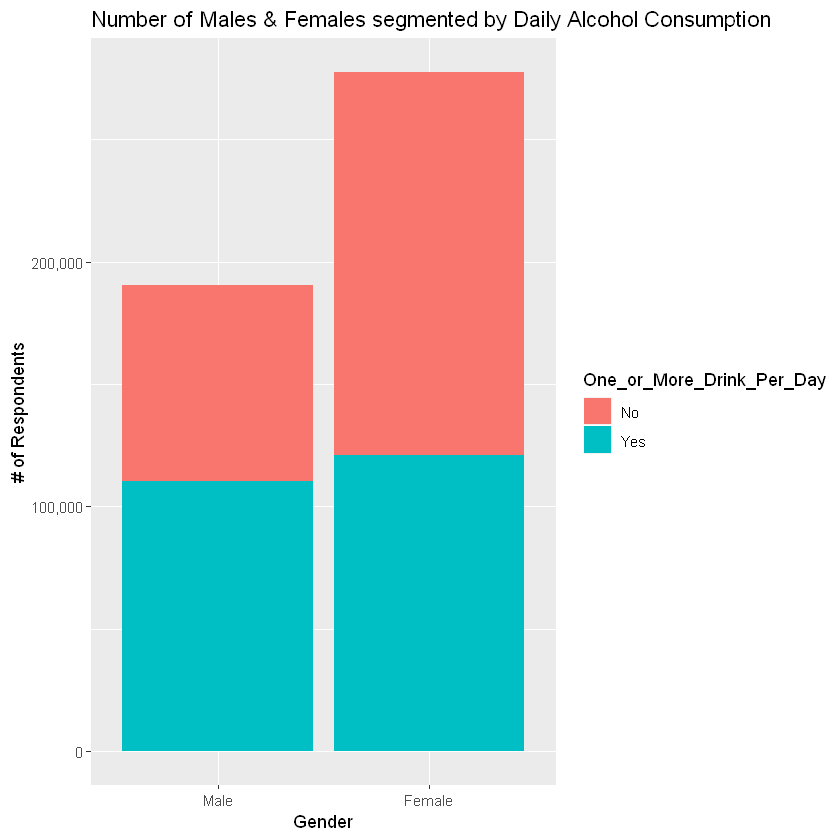

In [77]:
ggplot(data = gender_alcohol, aes(x = sex, fill = One_or_More_Drink_Per_Day)) +
        geom_bar() +
        ggtitle("Number of Males & Females segmented by Daily Alcohol Consumption") +
        scale_y_continuous(name="# of Respondents", labels = scales::comma) +
        scale_x_discrete(name="Gender")

It looks like the majority of men have more than 1 drink per day on average, whereas less than half of females have more than 1 drink per day on average.

In [78]:
gender_alcohol %>% group_by(sex, One_or_More_Drink_Per_Day) %>% summarise(count=n(), percent_of_total = n()/nrow(gender_alcohol))

sex,One_or_More_Drink_Per_Day,count,percent_of_total
Male,No,80224,0.1714580
Male,Yes,110199,0.2355218
Female,No,156488,0.3344525
Female,Yes,120982,0.2585677


Note that the percentages shown in the summary statistics above are out of the total respondents (men and women) and not each gender specifically. The differences in alcohol consumption may be due to both the frequency of ocassions where alcohol is consumed, as well as the quantity of alcohol consumed during each individual ocassion.

### Research Question 2 - Of veterans, is there a relationship between the number of bad mental health days and bad physical health days?

First, we need to filter for respondents who are veterans.

In [79]:
veterans <- brfss2013 %>% filter(veteran3 == "Yes")

There were 491,775 in our original dataset, of which 61,446 were veterans. Next, we check for extreme values by grouping by menthlth value.

In [80]:
cbind(veterans %>% group_by(menthlth) %>% summarise(count=n()), veterans %>% group_by(physhlth) %>% summarise(count=n()))

menthlth,count,physhlth,count
0,46931,0,38385
1,1221,1,1990
2,1861,2,2896
3,1083,3,1775
4,545,4,998
5,1323,5,1639
6,197,6,327
7,466,7,937
8,105,8,167
9,22,9,42


We see that there is one observation for menthlth that has a value of 5000 and one observation for physhlth that has a value of 60. The codebook defines these fields as "how many days during the past 30 days..." therefore, values greater than 30 are not reasonable so we will exclude these observations as well as any NA values.

In [81]:
veterans <- veterans %>% filter(menthlth <= 30, physhlth <=30)

Now that we have excluded the unreasonable extreme values and NA values, we can plot the data to see if there is a relationship. Because there are still a large number of observations, we can filter for only the mental/physical health relationships that have a large number of observations.

In [82]:
veterans_phys_ment <- veterans %>% group_by(physhlth, menthlth) %>% summarise(count=n())

Because we are working with discrete variables rather than continuous variables, it can be difficult to observe trends in a scatter plot. For visibility, we'll filter only for mental/physical health ratings that had at least 50 observations.

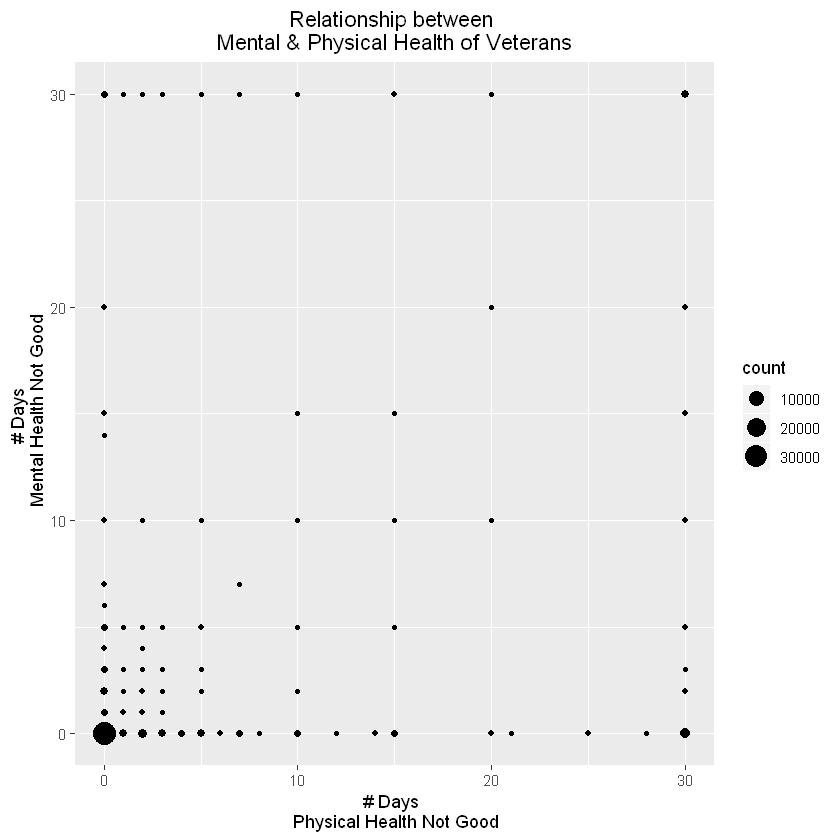

In [83]:
ggplot(data = veterans_phys_ment %>% filter(count > 50), aes(x = physhlth, y = menthlth, size = count)) +
    geom_point() +
    ggtitle("Relationship between \nMental & Physical Health of Veterans") +
    theme(plot.title = element_text(hjust = 0.5)) +
    xlab("# Days \n Physical Health Not Good") +
    ylab("# Days \n Mental Health Not Good")

It looks like there is a weak positive correlation between the number of days that mental health and physical health were reported as not good. Most of the observations are located on the edges, meaning that there were many veterans who reported 0 days of bad mental and/or physical health or all 30 days of bad mental and/or physical health.

In [84]:
veterans %>% summarise (mean_mental_notgood_days = mean(menthlth), mean_physical_notgood_days = mean(physhlth))

mean_mental_notgood_days,mean_physical_notgood_days
2.780571,4.802489


Based on the summary statistics, it looks like veterans report more days of not good physical health compared to mental health.

### Research Question 3: Are there differences in the number of hours of sleep by gender or age?

The survey was collected for adults (*i.e. people who were 18 years or older*), so we can filter out the five observations that had ages of 0-3. Additionally, ages above 80 were "collapsed" into a single group. We will exclude those as well since we don't have their exact ages. Lastly, we'll find the average hours slept for each age.

In [85]:
age_gender_sleep <- brfss2013 %>% filter(X_age80 <= 80, X_age80 >= 18, sex != 'NA', sleptim1<=24)
age_gender_avg_sleep <- age_gender_sleep %>% group_by(sex, X_age80) %>% summarise(mean_hours_slept = mean(sleptim1))
age_gender_avg_sleep_joined <- cbind(age_gender_avg_sleep %>% filter (sex == "Male"), age_gender_avg_sleep %>% filter (sex == "Female"))

We need to rename/remove columns, then transform the data in order to plot

In [86]:
colnames(age_gender_avg_sleep_joined)[colnames(age_gender_avg_sleep_joined)=="mean_hours_slept"] <- "male_mean_hours_slept"
colnames(age_gender_avg_sleep_joined)[colnames(age_gender_avg_sleep_joined)=="mean_hours_slept1"] <- "female_mean_hours_slept"
age_gender_avg_sleep_joined <- subset(age_gender_avg_sleep_joined, select = -c(sex, sex1, X_age801))
age_gender_avg_sleep_long <- melt(age_gender_avg_sleep_joined, id="X_age80")

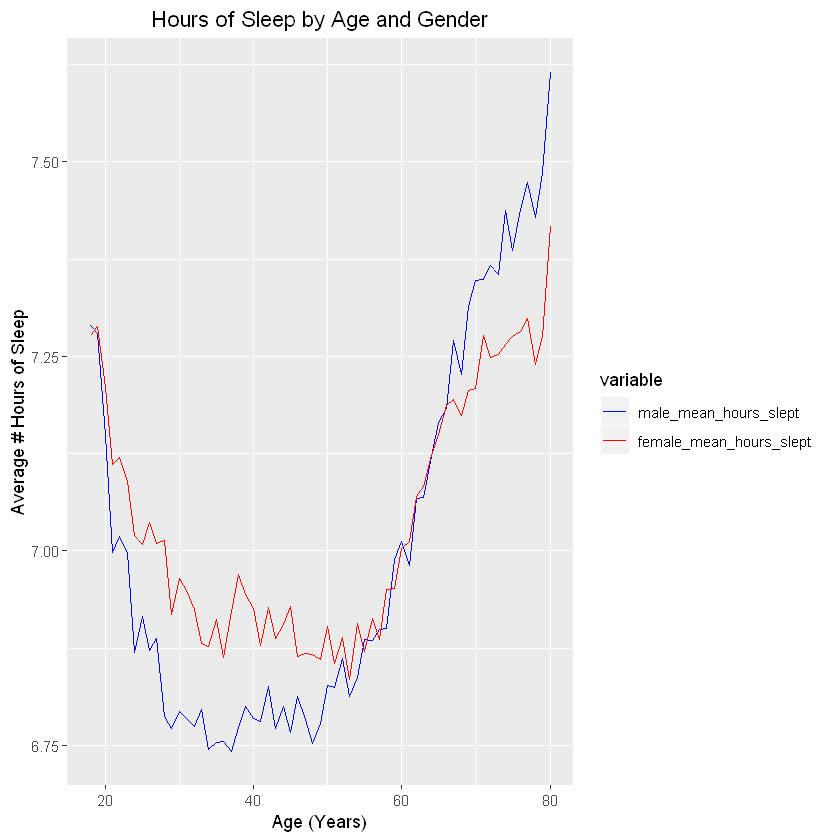

In [87]:
ggplot(data = age_gender_avg_sleep_long, aes(x=X_age80, y=value, color=variable)) +
    geom_line() +
    scale_colour_manual(values=c("blue", "red")) +
    ggtitle("Hours of Sleep by Age and Gender") +
    theme(plot.title = element_text(hjust = 0.5)) +
    xlab("Age (Years)") +
    ylab("Average # Hours of Sleep")

Overall it looks respondents between the ages of 30-55 get the least amount of sleep, but respondents that are over age 55 get more sleep. It also looks like women in most age groups sleep more on average than men in the same age groups.

In [88]:
cbind(age_gender_avg_sleep_joined %>% summarise(mean(male_mean_hours_slept), median(male_mean_hours_slept)),
age_gender_avg_sleep_joined %>% summarise(mean(female_mean_hours_slept), median(female_mean_hours_slept)))

mean(male_mean_hours_slept),median(male_mean_hours_slept),mean(female_mean_hours_slept),median(female_mean_hours_slept)
7.003687,6.886948,7.038573,7.003692


The summary statistics align with the graph showing that females have on average more sleep than men when aggregated across age groups.

### Conclusion

These preliminary analyses show cursory exploration of several variables from the BRFSS dataset. The visualizations aided in identifying trends, however, these do not imply causality since the data was not collected through random sampling.

Further areas of exploration would include analyzing trends by state and integrating data on public health spending to identify instances where health spending was low but reported health was good.